# Teil 4: Machine Learning Klassifikation

**Ziel:**
- Decision Tree Classifier auf 3 Features trainieren
- Feature Importance visualisieren
- Modell-Performance evaluieren

**Projektanforderung:**
> Trainieren Sie einen einfachen Decision Tree Classifier auf den drei Features und visualisieren Sie, an welchem Feature die erste Aufteilung erfolgt.

---

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for Machine Learning
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from pathlib import Path
import pickle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10



In [2]:
# Pfade
PROCESSED_DIR = Path('../data/processed')
RESULTS_DIR = Path('../results/figures')
MODELS_DIR = Path('../results/models')
MODELS_DIR.mkdir(exist_ok=True)

# DataFrame laden
df = pd.read_csv(PROCESSED_DIR / 'features_with_labels.csv')

print(f"Dataset geladen: {len(df)} Bilder")
print(f"\nLabel-Verteilung:")
print(df['label'].value_counts())

df.head()

Dataset geladen: 100 Bilder

Label-Verteilung:
label
Tumor     50
Normal    50
Name: count, dtype: int64


,file_path,label_is_malignant,stain_quality,patch_size_px,filename,entropy,variance,median,label
0,prepared_patches_p4\texture_patch_0053.png,1,1.0,512,texture_patch_0053.png,4.369851,0.017543,0.458693,Tumor
1,prepared_patches_p4\texture_patch_0087.png,1,2.0,512,texture_patch_0087.png,4.025140,0.005033,0.520631,Tumor
2,prepared_patches_p4\texture_patch_0047.png,0,4.0,512,texture_patch_0047.png,3.952590,0.016085,0.606405,Normal
3,prepared_patches_p4\texture_patch_0080.png,1,NaN,512,texture_patch_0080.png,4.777794,0.014092,0.504264,Tumor
4,prepared_patches_p4\texture_patch_0024.png,0,NaN,512,texture_patch_0024.png,4.256434,0.004517,0.539441,Normal


## 2. Daten vorbereiten

Wir brauchen:
- X: Features (Entropie, Varianz, Median)
- y: Labels (0 = Normal, 1 = Tumor)

In [3]:
# Features (X) und Labels (y) vorbereiten
feature_columns = ['entropy', 'variance', 'median']
X = df[feature_columns].values
y = df['label_is_malignant'].values  # 0 = Normal, 1 = Tumor

print("Daten vorbereitet:")
print(f"  X shape: {X.shape}  (Anzahl Samples × Anzahl Features)")
print(f"  y shape: {y.shape}  (Anzahl Labels)")
print(f"\nFeature-Matrix (erste 5 Zeilen):")
print(X[:5])
print(f"\nLabels (erste 10):")
print(y[:10])

Daten vorbereitet:
  X shape: (100, 3)  (Anzahl Samples × Anzahl Features)
  y shape: (100,)  (Anzahl Labels)

Feature-Matrix (erste 5 Zeilen):
[[4.36985054e+00 1.75426140e-02 4.58692549e-01]
 [4.02513953e+00 5.03275617e-03 5.20630588e-01]
 [3.95259039e+00 1.60849788e-02 6.06405098e-01]
 [4.77779362e+00 1.40921862e-02 5.04264314e-01]
 [4.25643433e+00 4.51668947e-03 5.39440784e-01]]

Labels (erste 10):
[1 1 0 1 0 0 0 1 1 0]


In [4]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,      # 30% für Test
    random_state=42,    # Reproduzierbarkeit
    stratify=y          # Gleiche Label-Verteilung in Train und Test
)

print("Train-Test Split:")
print(f"  Training: {len(X_train)} Samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Test:     {len(X_test)} Samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nLabel-Verteilung im Training-Set:")
print(f"  Normal (0): {np.sum(y_train == 0)} Samples")
print(f"  Tumor (1):  {np.sum(y_train == 1)} Samples")

Train-Test Split:
  Training: 70 Samples (70.0%)
  Test:     30 Samples (30.0%)

Label-Verteilung im Training-Set:
  Normal (0): 35 Samples
  Tumor (1):  35 Samples


## 3. Decision Tree Classifier trainieren

**Was ist ein Decision Tree?**
- Baumstruktur für Klassifikation
- Jeder Knoten = eine Entscheidung basierend auf einem Feature
- Blätter = finale Klassifikation (Tumor oder Normal)

**Vorteil:** Sehr interpretierbar - wir können sehen, welche Features wichtig sind!

In [5]:
# Decision Tree erstellen
clf = DecisionTreeClassifier(
    max_depth=3,           # Maximale Tiefe = 3 Levels
    random_state=42,       # Reproduzierbarkeit
    min_samples_split=4,   # Minimum 4 Samples für Split
    min_samples_leaf=2     # Minimum 2 Samples pro Blatt
)

# Modell trainieren
clf.fit(X_train, y_train)

print("Decision Tree trainiert")
print(f"\nModell-Parameter:")
print(f"  Max Depth: {clf.max_depth}")
print(f"  Actual Depth: {clf.get_depth()}")
print(f"  Number of Leaves: {clf.get_n_leaves()}")

Decision Tree trainiert

Modell-Parameter:
  Max Depth: 3
  Actual Depth: 3
  Number of Leaves: 8


## 4. Modell evaluieren

In [6]:
# Vorhersagen auf Test-Set
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

# Accuracy berechnen
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Modell-Performance:")
print(f"  Training Accuracy: {train_accuracy:.3f} ({train_accuracy*100:.1f}%)")
print(f"  Test Accuracy:     {test_accuracy:.3f} ({test_accuracy*100:.1f}%)")

if train_accuracy - test_accuracy > 0.1:
    print("\nHinweis: Große Differenz zwischen Train und Test → mögliches Overfitting")
else:
    print("\nGute Generalisierung - ähnliche Performance auf Train und Test")

Modell-Performance:
  Training Accuracy: 0.829 (82.9%)
  Test Accuracy:     0.633 (63.3%)

Hinweis: Große Differenz zwischen Train und Test → mögliches Overfitting


In [7]:
# Detaillierter Classification Report
print("Classification Report (Test-Set):\n")
print(classification_report(
    y_test, 
    y_pred_test,
    target_names=['Normal', 'Tumor']
))

print("Metriken erklärt:")
print("  Precision: Von allen als Tumor vorhergesagten, wie viele sind wirklich Tumor?")
print("  Recall: Von allen echten Tumoren, wie viele wurden erkannt?")
print("  F1-Score: Harmonisches Mittel von Precision und Recall")

Classification Report (Test-Set):

              precision    recall  f1-score   support

      Normal       0.62      0.67      0.65        15
       Tumor       0.64      0.60      0.62        15

    accuracy                           0.63        30
   macro avg       0.63      0.63      0.63        30
weighted avg       0.63      0.63      0.63        30

Metriken erklärt:
  Precision: Von allen als Tumor vorhergesagten, wie viele sind wirklich Tumor?
  Recall: Von allen echten Tumoren, wie viele wurden erkannt?
  F1-Score: Harmonisches Mittel von Precision und Recall


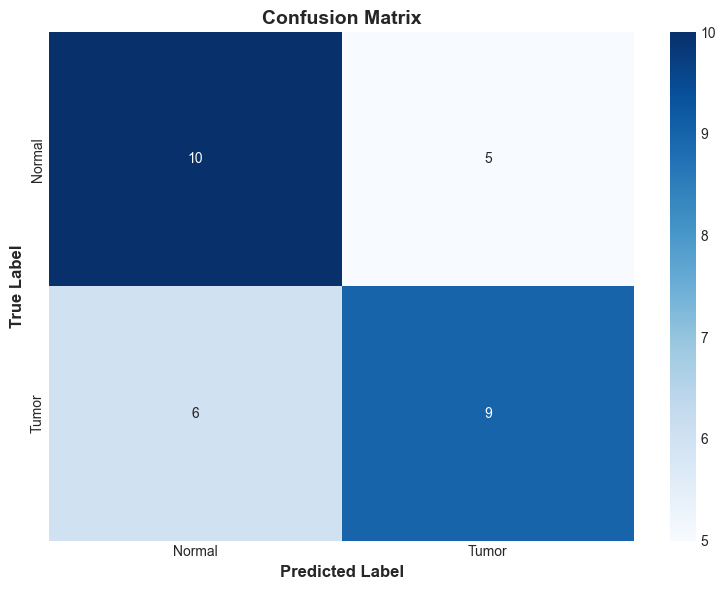

Confusion Matrix erklärt:
  True Negatives (TN):  10 - Korrekt als Normal erkannt
  False Positives (FP): 5 - Fälschlich als Tumor erkannt
  False Negatives (FN): 6 - Fälschlich als Normal erkannt
  True Positives (TP):  9 - Korrekt als Tumor erkannt

Plot gespeichert: results/figures/14_confusion_matrix.png


In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Tumor'],
    yticklabels=['Normal', 'Tumor'],
    ax=ax
)

ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '14_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion Matrix erklärt:")
print(f"  True Negatives (TN):  {cm[0,0]} - Korrekt als Normal erkannt")
print(f"  False Positives (FP): {cm[0,1]} - Fälschlich als Tumor erkannt")
print(f"  False Negatives (FN): {cm[1,0]} - Fälschlich als Normal erkannt")
print(f"  True Positives (TP):  {cm[1,1]} - Korrekt als Tumor erkannt")
print(f"\nPlot gespeichert: results/figures/14_confusion_matrix.png")

## 5. PROJEKTANFORDERUNG: Feature Importance visualisieren

Zeigt, welches Feature am wichtigsten für die Klassifikation ist.

In [9]:
# Feature Importance extrahieren
feature_importance = clf.feature_importances_

print("Feature Importance:")
for i, (feature, importance) in enumerate(zip(feature_columns, feature_importance)):
    print(f"  {feature:10s}: {importance:.4f} ({importance*100:.1f}%)")

# Wichtigstes Feature identifizieren
most_important_idx = np.argmax(feature_importance)
print(f"\nWichtigstes Feature: {feature_columns[most_important_idx]}")
print("Dieses Feature wird für die erste Aufteilung im Baum verwendet")

Feature Importance:
  entropy   : 0.4531 (45.3%)
  variance  : 0.2848 (28.5%)
  median    : 0.2621 (26.2%)

Wichtigstes Feature: entropy
Dieses Feature wird für die erste Aufteilung im Baum verwendet


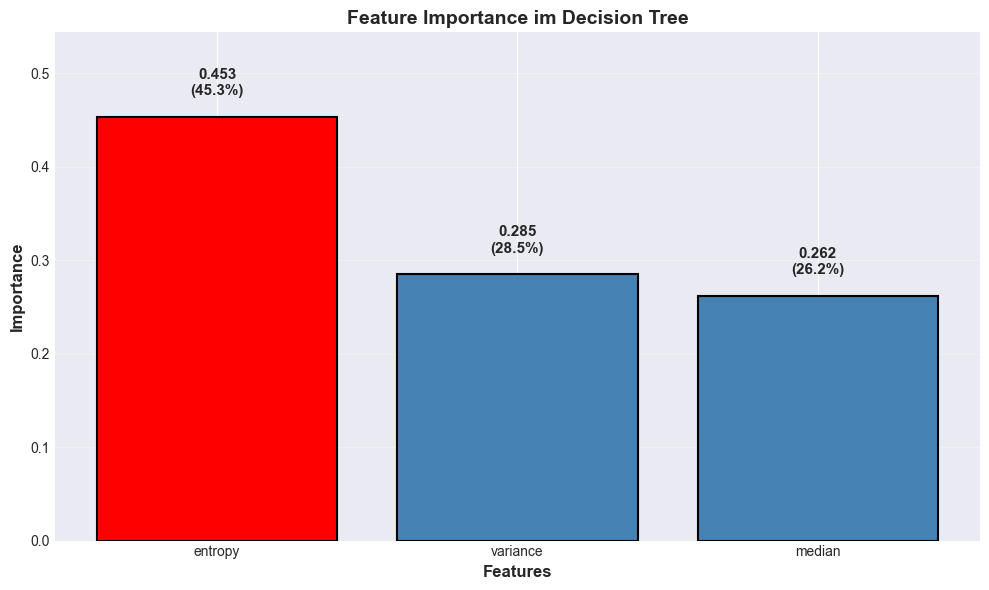

PROJEKTANFORDERUNG erfüllt
Plot gespeichert: results/figures/15_feature_importance.png


In [10]:
# Feature Importance als Barplot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if i == most_important_idx else 'steelblue' for i in range(len(feature_columns))]

bars = ax.bar(feature_columns, feature_importance, color=colors, edgecolor='black', linewidth=1.5)

# Werte auf Balken anzeigen
for bar, importance in zip(bars, feature_importance):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.02,
        f'{importance:.3f}\n({importance*100:.1f}%)',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance im Decision Tree', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(feature_importance) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '15_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("PROJEKTANFORDERUNG erfüllt")
print(f"Plot gespeichert: results/figures/15_feature_importance.png")

## 6. Decision Tree visualisieren

Zeigt die Struktur des Baumes - welche Splits werden gemacht?

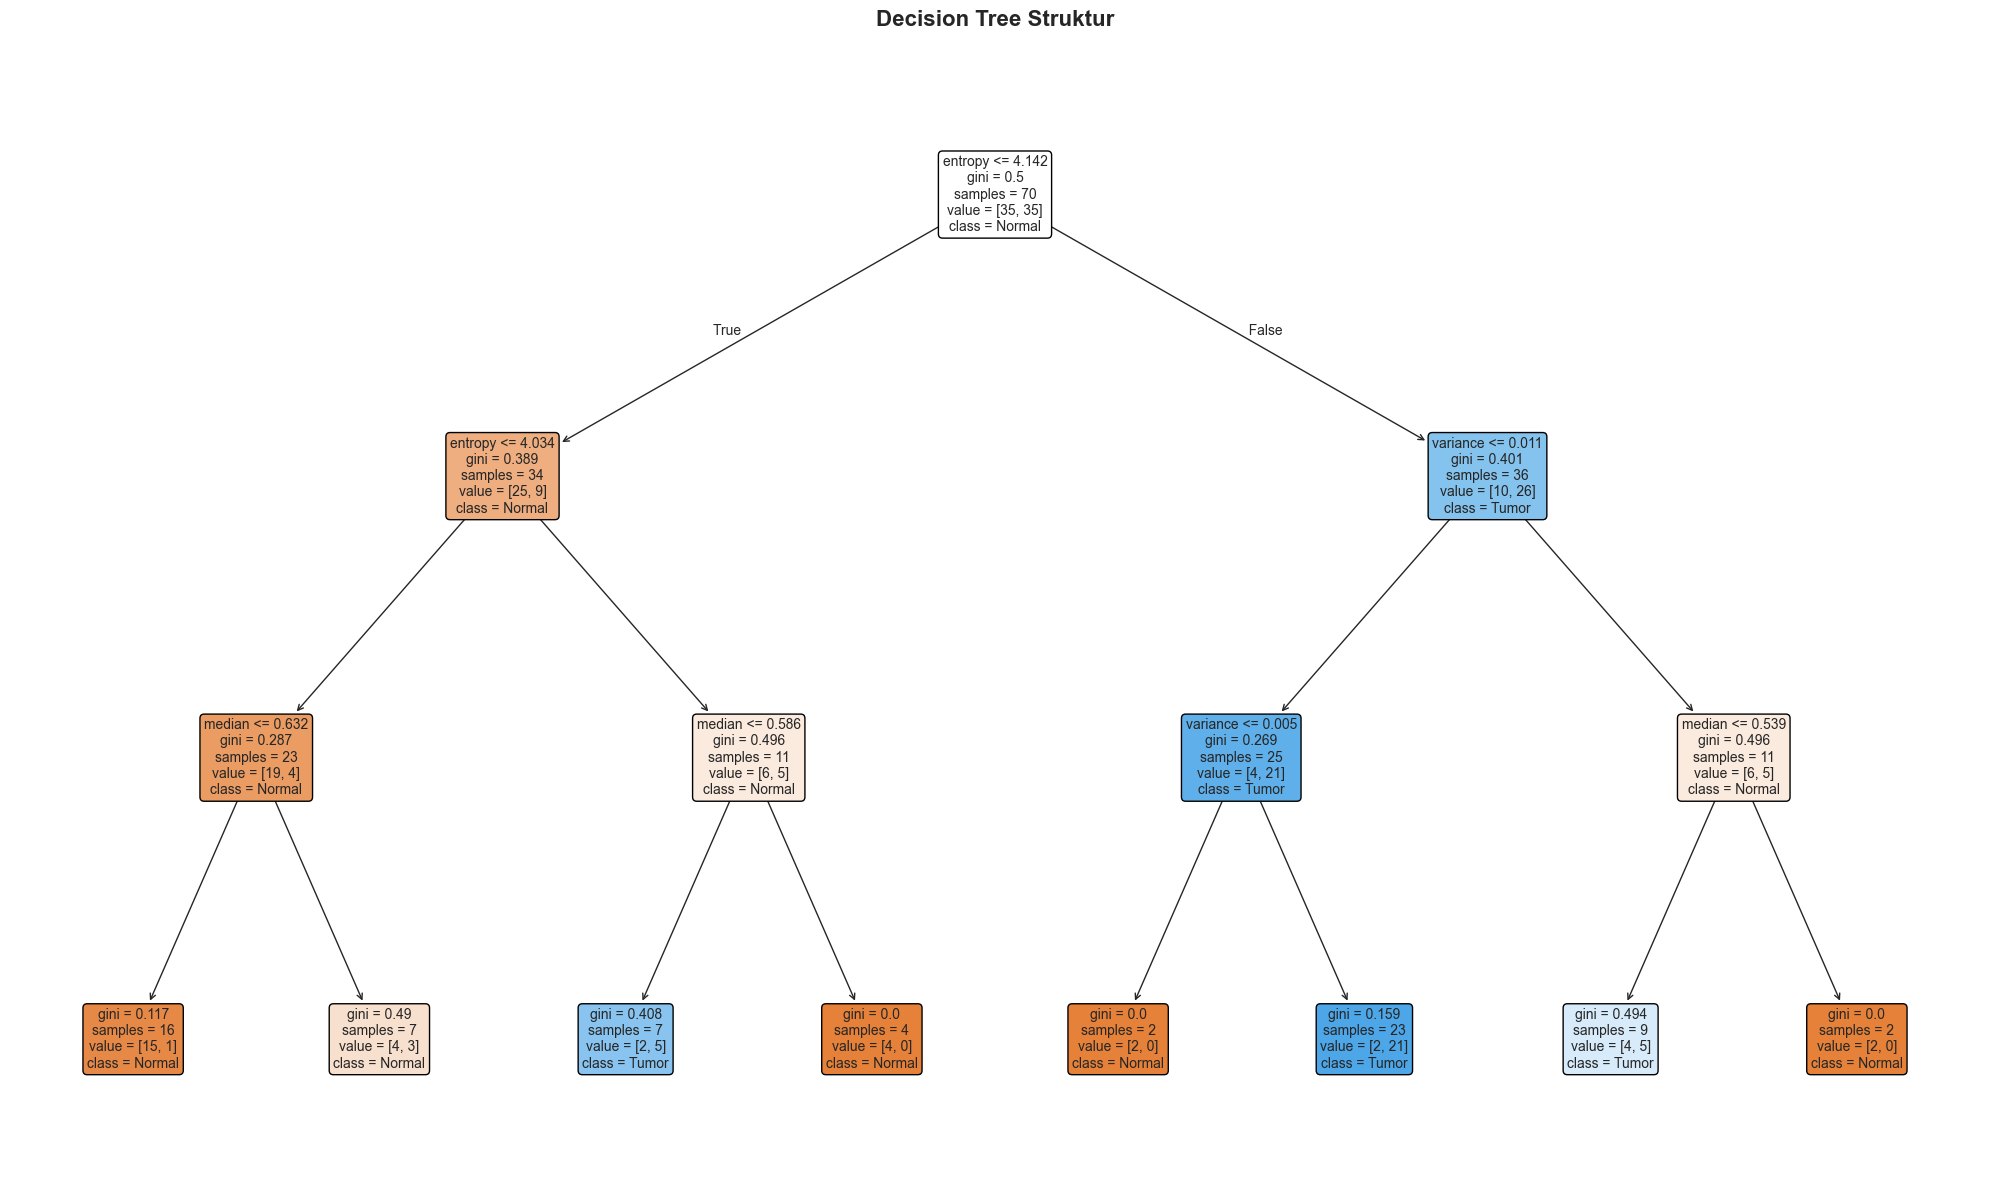

Tree-Visualisierung gespeichert: results/figures/16_decision_tree_structure.png

Wie man den Baum liest:
  - Oberster Knoten (root): Erste Aufteilung
  - Jeder Knoten zeigt: Feature, Threshold, Samples, Klassen-Verteilung
  - Farbe: Orange = mehr Tumor, Blau = mehr Normal
  - Blätter (unten): Finale Vorhersage


In [11]:
# Decision Tree visualisieren
fig, ax = plt.subplots(figsize=(20, 12))

plot_tree(
    clf,
    feature_names=feature_columns,
    class_names=['Normal', 'Tumor'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)

ax.set_title('Decision Tree Struktur', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '16_decision_tree_structure.png', dpi=150, bbox_inches='tight')
plt.show()

print("Tree-Visualisierung gespeichert: results/figures/16_decision_tree_structure.png")
print("\nWie man den Baum liest:")
print("  - Oberster Knoten (root): Erste Aufteilung")
print("  - Jeder Knoten zeigt: Feature, Threshold, Samples, Klassen-Verteilung")
print("  - Farbe: Orange = mehr Tumor, Blau = mehr Normal")
print("  - Blätter (unten): Finale Vorhersage")

## 7. Modell speichern

In [12]:
# Modell als pickle-Datei speichern
model_path = MODELS_DIR / 'decision_tree_classifier.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(clf, f)

print(f"Modell gespeichert: {model_path}")
print("\nDas Modell kann später geladen werden mit:")
print("  with open('model.pkl', 'rb') as f:")
print("      clf = pickle.load(f)")

Modell gespeichert: ../results/models/decision_tree_classifier.pkl

Das Modell kann später geladen werden mit:
  with open('model.pkl', 'rb') as f:
      clf = pickle.load(f)


## 8. Zusammenfassung Teil 4

### Was wir erreicht haben:

1. Decision Tree Classifier trainiert auf 3 Features
2. Modell-Performance evaluiert:
   - Accuracy, Precision, Recall, F1-Score
   - Confusion Matrix
3. **Feature Importance analysiert** (Projektanforderung erfüllt)
4. Tree-Struktur visualisiert
5. Modell gespeichert

### Erkenntnisse:

**Welches Feature ist am wichtigsten?**
- Siehe Feature Importance Plot
- Dieses Feature wird für die erste Aufteilung verwendet

**Wie gut funktioniert das Modell?**
- Test Accuracy zeigt Generalisierung
- Confusion Matrix zeigt, wo Fehler gemacht werden

**Für die Präsentation:**
- Feature Importance Plot → zeigt wichtigstes Feature
- Tree-Visualisierung → zeigt Entscheidungslogik
- Confusion Matrix → zeigt Performance

---

### ALLE 4 PROJEKTTEILE KOMPLETT

**Teil 1:** Farbraum-Analyse
**Teil 2:** Feature-Extraktion
**Teil 3:** Statistische Analyse & Visualisierung
**Teil 4:** Machine Learning Klassifikation

### Nächste Schritte:

1. Code aufräumen und dokumentieren
2. Alle Plots für Präsentation sammeln
3. README aktualisieren mit Ergebnissen
4. Präsentation vorbereiten

---

**Status:** PROJEKT KOMPLETT

**Bereit für:** Code-Review und Präsentationsvorbereitung

---